<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Spaceship-Titanic/blob/additional_features/1_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [117]:
# google drive
from google.colab import drive

# data
import pandas as pd

# math
import numpy as np

# plotting
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split

## PEP8 code standard

In [118]:
# PEP 8
# %%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/


In [119]:
from nbpep8.nbpep8 import pep8

# Helper functions

In [120]:
def prepare_pivot_table(df_, values_, index_, aggfunc_):
    table = pd.pivot_table(
        df_,
        values=values_,
        index=index_,
        aggfunc=aggfunc_
    )

    table[f'%'] = \
        table['sum'][values_[0]] \
        / table['count'][values_[0]]
    
    return table

## Importing custom packages

In [121]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Spaceship-Titanic/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

# pep8(_ih)

In [122]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils
        # other modules
    ]
)

from path_manager import PathManager
from sklearn_utils import (
    nan_statistics,
    visualize_datasets_distributions
)

# Set up paths

In [123]:
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 8
MODELS_TRIAL = 1
COMPETITION_PATH = gdrive_path + 'ML/Competitions/6.SpaceshipTitanic/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Data/preproc_trial_8 already exists
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Models/trial_1 already exists


# Frame the problem

1. Type of task?
	- Supervised learning
	- Classification
	- Batch learning (not online)
2. How company will benefit from task? How model will be used?
    - *To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.*
3. Algorithms?
    - Log regression baseline
    - FFNN
    - Random forest
    - SVM classification
4. Performance measure?
    - Cross entropy loss for binary classification
    - F1 metrics for performance (check the class balance)
5. Domain knowledge?
    - None
6. What the current solution looks like (if any)?
    - No current solution
7. Are there hypotheses to build? (Before looking at the data!)
    - None

# Download the data

In [124]:
manager.train_path

'/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Data/train.csv'

In [125]:
df_test = pd.read_csv(manager.test_path, index_col='Unnamed: 0')

df_train = pd.read_csv(manager.train_path, index_col='Unnamed: 0')
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,gender
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1


In [126]:
train_cols = set(df_train.columns)
test_cols = set(df_test.columns)

assert train_cols - test_cols == {'Transported'}

# Quick look at the data (conclusions are described in journal)

In [ ]:
from sklearn_utils import nan_statistics


_ = nan_statistics(df_train)

Col -- Nan percentage
CryoSleep 2.4962613597147127
ShoppingMall 2.392729782583688
VIP 2.3352122397331185
HomePlanet 2.312205222592891
Name 2.300701714022777
Cabin 2.289198205452663
VRDeck 2.1626596111814105
FoodCourt 2.105142068330841
Spa 2.105142068330841
Destination 2.093638559760727
RoomService 2.082135051190613
Age 2.0591280340503855


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    8693 non-null   int64  
 1   PassengerId   8693 non-null   object 
 2   HomePlanet    8492 non-null   object 
 3   CryoSleep     8476 non-null   object 
 4   Cabin         8494 non-null   object 
 5   Destination   8511 non-null   object 
 6   Age           8514 non-null   float64
 7   VIP           8490 non-null   object 
 8   RoomService   8512 non-null   float64
 9   FoodCourt     8510 non-null   float64
 10  ShoppingMall  8485 non-null   float64
 11  Spa           8510 non-null   float64
 12  VRDeck        8505 non-null   float64
 13  Name          8493 non-null   object 
 14  Transported   8693 non-null   bool   
 15  gender        8693 non-null   int64  
dtypes: bool(1), float64(6), int64(2), object(7)
memory usage: 1.0+ MB


In [ ]:
df_train.fillna(0).describe()

,Unnamed: 0,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,gender
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,4346.000000,28.234326,220.009318,448.434027,169.572300,304.588865,298.261820,0.722650
std,2509.597278,14.912090,660.519050,1595.790627,598.007164,1125.562559,1134.126417,0.447716
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2173.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4346.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6519.000000,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000,1.000000
max,8692.000000,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


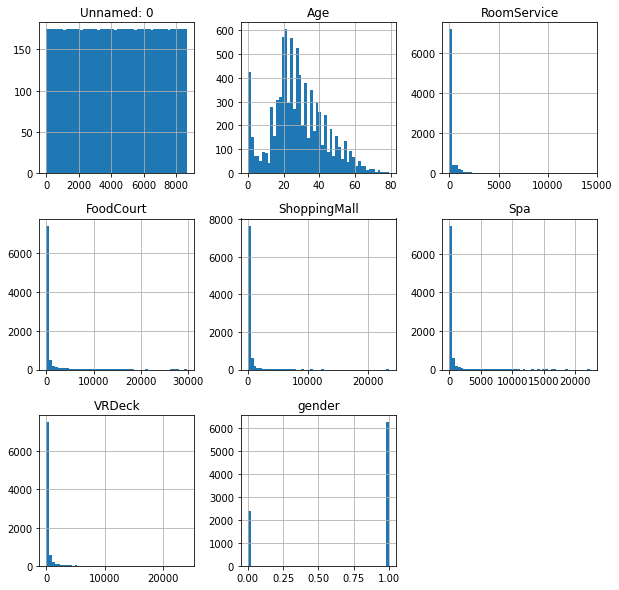

In [ ]:
_ = df_train.\
    fillna(0, inplace=False).\
    hist(bins=50, figsize=(10, 10))

## Class balance

As we see below, the training dataset is perfectly balanced

In [ ]:
df_train['Transported'].value_counts() / df_train.shape[0]

True     0.503624
False    0.496376
Name: Transported, dtype: float64

## Are train and test features similarly distributed?

Visualizing datasets distributions


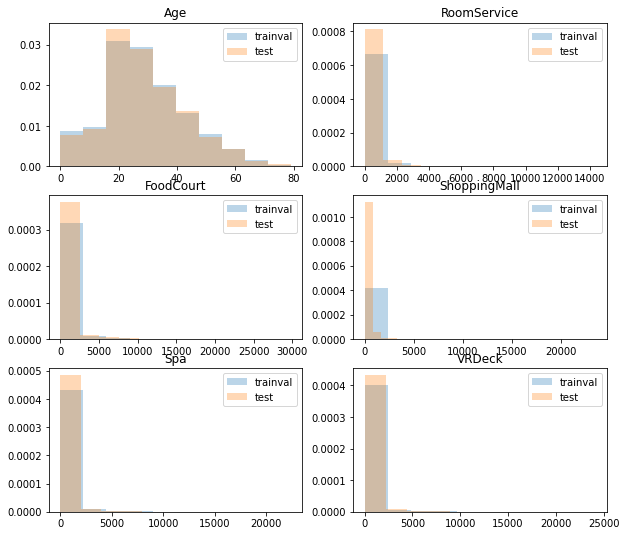

In [ ]:
visualize_datasets_distributions(
    {
        'trainval': df_train,
        'test': df_test,
    },
    list(
        df_test.columns[df_test.dtypes == 'float64']
    ),
    grid_width_=2,
    figwidth_=10
)

# Create trainval and test sets

In [127]:
RANDOM_STATE = 42
TEST_PERCENTAGE = 0.1

df_trainval_sample, df_test_sample = \
    train_test_split(
        df_train,
        test_size=TEST_PERCENTAGE,
        random_state=RANDOM_STATE,
        shuffle=True,
        stratify=df_train['Transported']
    )

In [128]:
print(df_trainval_sample['Transported'].value_counts(normalize=True))
print(df_test_sample['Transported'].value_counts(normalize=True))

True     0.503643
False    0.496357
Name: Transported, dtype: float64
True     0.503448
False    0.496552
Name: Transported, dtype: float64


Visualizing datasets distributions


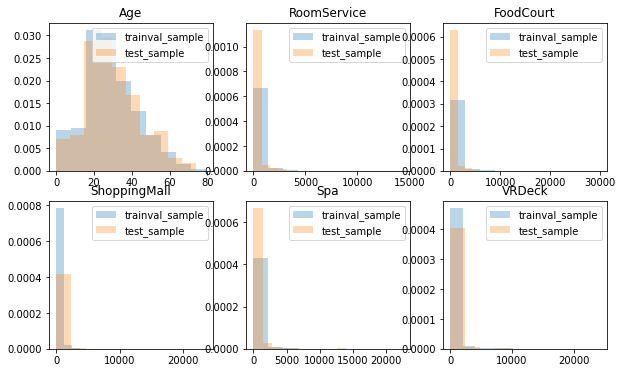

In [129]:
visualize_datasets_distributions(
    {
        'trainval_sample': df_trainval_sample,
        'test_sample': df_test_sample
    },
    columns_=df_trainval_sample.columns[
        df_trainval_sample.dtypes=='float64'
    ]
)

# Data exploration (with trainval set)

## Sample an exploration dataset

We do not sample a subset out of the trainval dataset, because the size of ~7000 instances is not too large. However, to preserve the original data, we will work with the copy of the dataset

In [ ]:
df_exploration = df_trainval_sample.copy()

In [ ]:
df_exploration.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'gender'],
      dtype='object')

## Passenger Id

In [ ]:
df_exploration.PassengerId

3388    3645_02
1013    1083_01
2483    2663_01
4431    4710_01
951     1012_01
         ...   
4406    4678_01
4409    4680_02
4964    5298_01
3049    3294_01
6677    7040_01
Name: PassengerId, Length: 7823, dtype: object

In [ ]:
df_exploration.PassengerId.isna().sum()

0

In [ ]:
def get_group(val):
    return int(val.split('_')[0])

df_exploration['PassengerGroup'] = \
    df_exploration['PassengerId'].map(get_group)

In [ ]:
def get_position(val):
    return int(val.split('_')[1])


df_exploration['PassengerPosition'] = \
    df_exploration['PassengerId'].map(get_position)

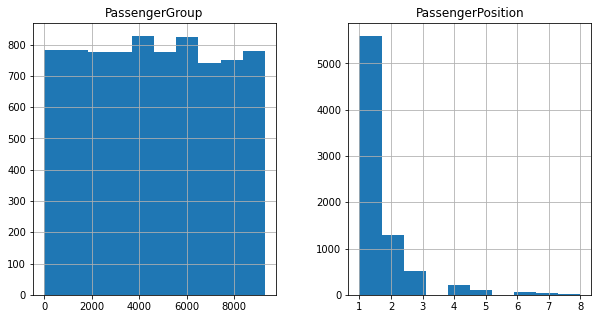

In [ ]:
_ = df_exploration[['PassengerGroup', 'PassengerPosition']].hist(
    figsize=(10, 5)
)

In [ ]:
value_counts_group = df_exploration['PassengerGroup'].value_counts()

def get_group_size(val):
    return value_counts_group.loc[val]

df_exploration['GroupSize'] = \
    df_exploration['PassengerGroup'].map(get_group_size)

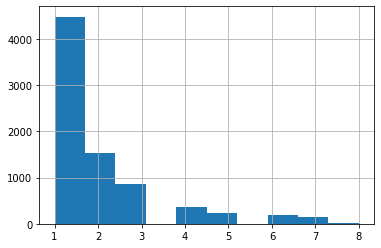

In [ ]:
df_exploration['GroupSize'].hist()

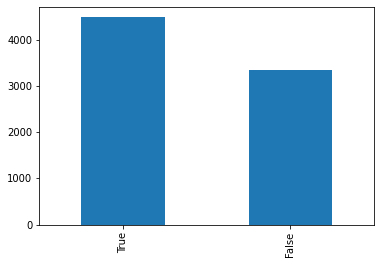

In [ ]:
df_exploration['IsSingleInTheGroup'] = \
    df_exploration['GroupSize'] == 1

df_exploration['IsSingleInTheGroup'].value_counts().plot(kind='bar')

In [ ]:
home_planet_table = pd.pivot_table(
    df_exploration,
    values=['Transported'],
    index=['IsSingleInTheGroup'],
    aggfunc=['sum', 'count']
)

home_planet_table['Transported %'] = \
    home_planet_table['sum']['Transported'] \
    / home_planet_table['count']['Transported']

home_planet_table

,sum,count,Transported %
,Transported,Transported,
IsSingleInTheGroup,,,
False,1886,3339,0.564840
True,2054,4484,0.458073


## Home planet

In [ ]:
df_exploration.HomePlanet.value_counts()

Earth     4134
Europa    1909
Mars      1596
Name: HomePlanet, dtype: int64

In [ ]:
home_planet_table = pd.pivot_table(
    df_exploration,
    values=['Transported'],
    index=['HomePlanet'],
    aggfunc=['sum', 'count']
)

home_planet_table['Transported %'] = \
    home_planet_table['sum']['Transported'] \
    / home_planet_table['count']['Transported']

home_planet_table

,sum,count,Transported %
,Transported,Transported,
HomePlanet,,,
Earth,1751,4134,0.423561
Europa,1252,1909,0.655841
Mars,844,1596,0.528822


## CryoSleep

In [ ]:
df_exploration.CryoSleep.isna().sum() / len(df_exploration)

0.02492649878563211

In [ ]:
cryo_sleep_table = pd.pivot_table(
    df_exploration,
    values=['Transported'],
    index=['CryoSleep'],
    aggfunc=['sum', 'count']
)

cryo_sleep_table['Transported %'] = \
    cryo_sleep_table['sum']['Transported'] \
    / cryo_sleep_table['count']['Transported']

cryo_sleep_table

,sum,count,Transported %
,Transported,Transported,
CryoSleep,,,
False,1626,4913,0.330959
True,2220,2715,0.817680


## Cabin

In [ ]:
print(df_exploration.Cabin.nunique())
df_exploration.Cabin.value_counts()

5994


G/734/S     7
E/13/S      7
C/137/S     7
G/1368/P    7
F/1411/P    7
           ..
G/1465/P    1
F/131/P     1
E/76/S      1
F/915/S     1
G/1150/S    1
Name: Cabin, Length: 5994, dtype: int64

## Destination

In [ ]:
df_exploration.Destination.value_counts()

TRAPPIST-1e      5306
55 Cancri e      1640
PSO J318.5-22     718
Name: Destination, dtype: int64

In [ ]:
destination_table = prepare_pivot_table(
    df_exploration,
    ['Transported'],
    ['Destination'],
    ['sum', 'count']
)

destination_table

,sum,count,%
,Transported,Transported,
Destination,,,
55 Cancri e,1000,1640,0.609756
PSO J318.5-22,364,718,0.506964
TRAPPIST-1e,2495,5306,0.470222


## Age

In [ ]:
N_QUANTILES = 17
df_exploration['Age_binned'] = pd.cut(
    df_exploration['Age'],
    # q=N_QUANTILES,
    bins=[-1, 5, 18, 30, 50, 100],
    duplicates='drop'
    # labels=[i for i in range(N_QUANTILES)]
)

prepare_pivot_table(
    df_exploration,
    values_=['Transported'],
    index_=['Age_binned'],
    aggfunc_=['sum', 'count'],
)

,sum,count,%
,Transported,Transported,
Age_binned,,,
"(-1, 5]",349,461,0.757050
"(5, 18]",671,1233,0.544201
"(18, 30]",1377,2923,0.471091
"(30, 50]",1159,2407,0.481512
"(50, 100]",310,642,0.482866


In [ ]:
N_QUANTILES = 17
df_exploration['Age_binned'] = pd.qcut(
    df_exploration['Age'],
    q=N_QUANTILES,
    duplicates='drop'
    # labels=[i for i in range(N_QUANTILES)]
)

prepare_pivot_table(
    df_exploration,
    values_=['Transported'],
    index_=['Age_binned'],
    aggfunc_=['sum', 'count'],
)

,sum,count,%
,Transported,Transported,
Age_binned,,,
"(-0.001, 5.0]",349,461,0.757050
"(5.0, 14.0]",297,529,0.561437
"(14.0, 17.0]",230,411,0.559611
"(17.0, 19.0]",269,551,0.488203
"(19.0, 21.0]",232,544,0.426471
"(21.0, 22.0]",121,265,0.456604
"(22.0, 24.0]",255,559,0.456172
"(24.0, 26.0]",218,455,0.479121


Text(0.5, 0, 'Age')

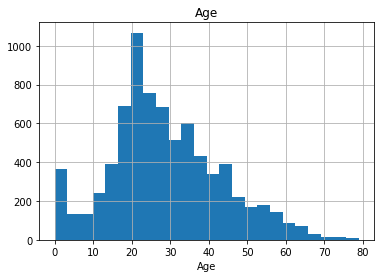

In [ ]:
ax = df_exploration.Age.hist(bins=24)
ax.set_title('Age')
ax.set_xlabel('Age')

## VIP

In [ ]:
df_exploration.VIP.value_counts()

False    7461
True      180
Name: VIP, dtype: int64

In [ ]:
prepare_pivot_table(
    df_exploration,
    ['Transported'],
    ['VIP'],
    ['sum', 'count']
)

,sum,count,%
,Transported,Transported,
VIP,,,
False,3780,7461,0.506634
True,69,180,0.383333


In [ ]:
prepare_pivot_table(
    df_exploration,
    ['Transported'],
    ['VIP', 'CryoSleep'],
    ['sum', 'count']
)

sum       count         %
                Transported Transported          
VIP   CryoSleep                                  
False False            1534        4643  0.330390
      True             2154        2632  0.818389
True  False              49         158  0.310127
      True               19          19  1.000000

## RoomService

- **99% of the population have relatively low payments for the luxury services, and only 1% paid large amounts of money**

3108.379199999996

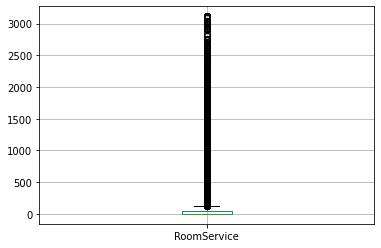

In [ ]:
df_test_ = df_exploration.copy()
df_test_['RoomService'] = df_exploration['RoomService'].clip(
    upper = df_exploration['RoomService'].quantile(0.99)
)
df_test_.boxplot(['RoomService'])
df_test_.RoomService.quantile(0.99)

3116.1199999999953

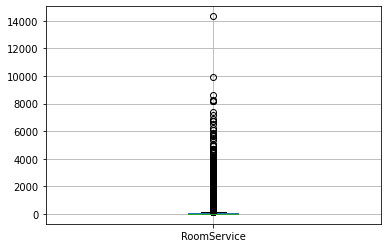

In [ ]:
df_exploration.boxplot(['RoomService'])
df_exploration.RoomService.quantile(0.99)

In [ ]:
df_exploration.RoomService.describe()

count     7660.000000
mean       226.216710
std        666.663049
min          0.000000
25%          0.000000
50%          0.000000
75%         49.000000
max      14327.000000
Name: RoomService, dtype: float64

In [ ]:
# 63% of roomservice features are equal to 0
len(df_exploration[df_exploration.RoomService == 0]) \
    / len(df_exploration)

0.6393966509011888

In [ ]:
df_exploration['RoomServiceBiggerThanZero'] = \
    df_exploration.RoomService > 0.0

In [ ]:
prepare_pivot_table(
    df_exploration,
    ['Transported'],
    ['RoomServiceBiggerThanZero'],
    ['count', 'sum']
)

,count,sum,%
,Transported,Transported,
RoomServiceBiggerThanZero,,,
False,5165,3235,0.626331
True,2658,705,0.265237


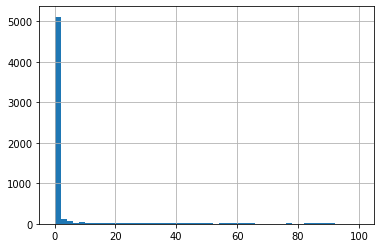

In [ ]:
# df_exploration.RoomService.describe()
df_exploration.loc[
    df_exploration.RoomService <= 100,
    ['RoomService']
].RoomService.hist(bins=50)
# RoomService.hist(bins=50)

## VRDeck

5739.599999999954

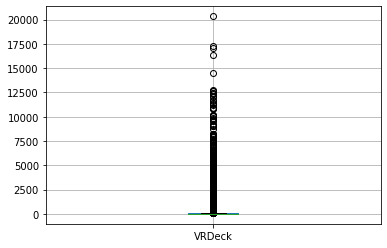

In [ ]:
df_exploration.boxplot(['VRDeck'])
df_exploration['VRDeck'].quantile(0.99)

## Spa

- Again, same observation - only top 1% of population paid extreme money for the luxuries, while 99% have moderate sums

5385.200000000001

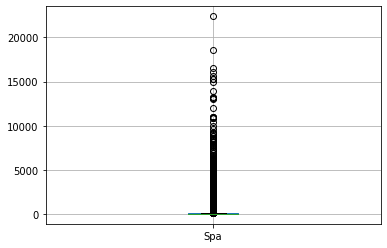

In [ ]:
df_exploration.boxplot(['Spa'])
df_exploration.Spa.quantile(0.99)

## FoodCourt

8188.549999999989

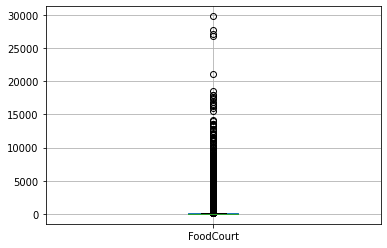

In [ ]:
df_exploration.boxplot(['FoodCourt'])
df_exploration['FoodCourt'].quantile(0.99)

In [ ]:
# The majority did not pay for the luxury amenities
len(df_exploration[df_exploration.FoodCourt == 0]) \
    / len(df_exploration)

0.6271251438067238

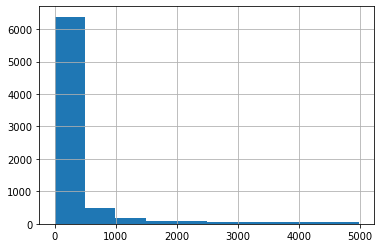

In [ ]:
df_exploration[
    df_exploration.FoodCourt < 5000
].FoodCourt.hist()

## ShoppingMall

2305.930000000001

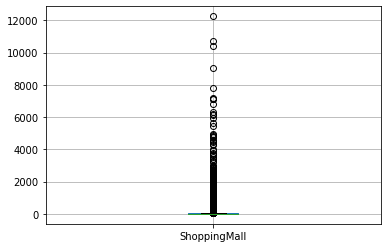

In [ ]:
df_exploration.boxplot(['ShoppingMall'])
df_exploration.ShoppingMall.quantile(0.99)

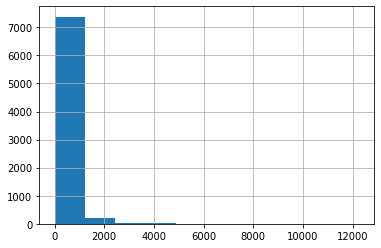

In [ ]:
df_exploration.ShoppingMall.hist()

In [ ]:
df_exploration[
    ~(df_exploration.ShoppingMall > 0)
    & ~(df_exploration.FoodCourt > 0) 
    & ~(df_exploration.VRDeck > 0)
    & ~(df_exploration.Spa > 0)
    & ~(df_exploration.RoomService > 0)
].shape  # Transported.value_counts(normalize=True)

(3283, 16)

In [ ]:
df_exploration[
    (df_exploration.ShoppingMall == 0)
    & (df_exploration.FoodCourt == 0) 
    & (df_exploration.VRDeck == 0)
    & (df_exploration.Spa == 0)
    & (df_exploration.RoomService == 0)
].shape[0] / len(df_exploration)

0.37274702799437553

In [ ]:
df_exploration[
    (df_exploration.ShoppingMall > 0)
    | (df_exploration.FoodCourt > 0) 
    | (df_exploration.VRDeck > 0)
    | (df_exploration.Spa > 0)
    | (df_exploration.RoomService > 0)
].shape[0] / len(df_exploration)

0.5803400230090758

In [ ]:
df_exploration['NoLuxuriesBought'] = \
    (df_exploration.ShoppingMall == 0) \
    & (df_exploration.FoodCourt == 0) \
    & (df_exploration.VRDeck == 0) \
    & (df_exploration.Spa == 0) \
    & (df_exploration.RoomService == 0)

In [ ]:
 def check_is_false(val):
     return val is False

df_exploration['BoughtAtLeastOneLuxury'] = \
    df_exploration['NoLuxuriesBought'].map(check_is_false)

In [ ]:
df_exploration['BoughtAtLeastOneLuxury'].value_counts()
# df_exploration['NoLuxuriesBought'].value_counts()

True     4907
False    2916
Name: BoughtAtLeastOneLuxury, dtype: int64

In [ ]:
prepare_pivot_table(
    df_exploration,
    ['Transported'],
    ['BoughtAtLeastOneLuxury'],
    ['sum', 'count']
)

,sum,count,%
,Transported,Transported,
BoughtAtLeastOneLuxury,,,
False,2279,2916,0.781550
True,1661,4907,0.338496


In [ ]:
prepare_pivot_table(
    df_exploration,
    ['Transported'],
    ['NoLuxuriesBought'],
    ['sum', 'count']
)

,sum,count,%
,Transported,Transported,
NoLuxuriesBought,,,
False,1661,4907,0.338496
True,2279,2916,0.781550


## Name

In [ ]:
df_exploration.Name.nunique() / len(df_exploration)

0.9740508756231625

## Transported (target variable)

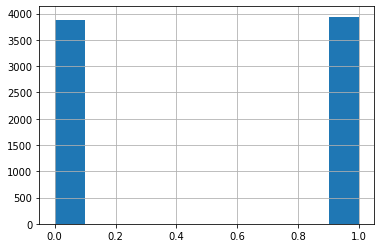

In [ ]:
df_exploration.Transported.astype('uint8').hist()

In [ ]:
df_exploration.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'gender', 'PassengerGroup', 'PassengerPosition',
       'GroupSize', 'IsSingleInTheGroup'],
      dtype='object')

## Gender

In [ ]:
df_exploration['gender'].value_counts()

prepare_pivot_table(
    df_exploration,
    ['Transported'],
    ['gender'],
    ['sum', 'count']
)

,sum,count,%
,Transported,Transported,
gender,,,
0,1144,2136,0.535581
1,2796,5687,0.491648


# Feature engineering

## Is a baby

In [130]:
df_exploration['IsBaby'] = df_exploration['Age'].between(0, 5, 'both')

In [131]:
prepare_pivot_table(
    df_exploration,
    values_=['Transported'],
    index_=['IsBaby'],
    aggfunc_=['sum', 'count']
)

,sum,count,%
,Transported,Transported,
IsBaby,,,
False,3591,7362,0.487775
True,349,461,0.757050


## Deck

In [ ]:
def get_deck(val):
    if len(val) == 0:
        return 'NAN'
    return val.split('/')[0]

df_exploration['Deck'] = df_exploration.Cabin \
    .astype('str') \
    .fillna('') \
    .map(get_deck)

In [ ]:
deck_table = prepare_pivot_table(
    df_exploration,
    ['Transported'],
    ['Deck'],
    ['sum', 'count']
)
deck_table

,sum,count,%
,Transported,Transported,
Deck,,,
A,111,227,0.488987
B,508,693,0.733045
C,450,671,0.670641
D,194,431,0.450116
E,289,793,0.364439
F,1108,2520,0.439683
G,1187,2302,0.515639
T,1,4,0.250000


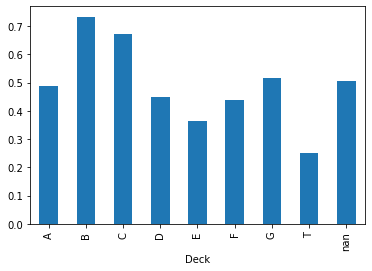

In [ ]:
deck_table['%'].plot(kind='bar')

## Num (of deck)

In [ ]:
df_exploration.Cabin = df_exploration.Cabin.astype(str)

In [ ]:
df_exploration.Cabin.value_counts()

nan         182
G/1368/P      7
G/981/S       7
G/734/S       7
E/13/S        7
           ... 
G/1465/P      1
F/131/P       1
E/76/S        1
F/915/S       1
G/1150/S      1
Name: Cabin, Length: 5995, dtype: int64

In [ ]:
def get_deck_num(deck):
    if deck == 'nan':
        return '0'
    else:
        split_items = deck.split('/')
        return deck.split('/')[1]


df_exploration['DeckNum'] = df_exploration.Cabin \
    .map(get_deck_num)

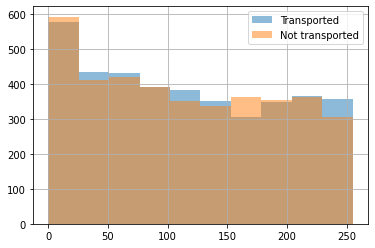

In [ ]:
ax = df_exploration.loc[
    df_exploration['Transported'] == True,
    :
].DeckNum.astype('uint8').hist(
    alpha=0.5,
    label='Transported'
)

ax.hist(
    df_exploration.loc[
        df_exploration['Transported'] == False,
        :
    ].DeckNum.astype('uint8'),
    alpha=0.5,
    label='Not transported'
)

ax.legend()

## Side (of deck)

In [ ]:
df_exploration.Cabin.isna().sum()

0

In [ ]:
def get_deck_side(cabin):
    if cabin == 'nan':
        return 'NA'
    else:
        return cabin.split('/')[2]

df_exploration['DeckSide'] = \
    df_exploration.Cabin \
    .map(get_deck_side)

In [ ]:
df_exploration['DeckSide'].value_counts()

S     3835
P     3806
NA     182
Name: DeckSide, dtype: int64

In [ ]:
prepare_pivot_table(
    df_exploration,
    ['Transported'],
    ['DeckSide'],
    ['sum', 'count']
)

,sum,count,%
,Transported,Transported,
DeckSide,,,
NA,92,182,0.505495
P,1717,3806,0.451130
S,2131,3835,0.555671


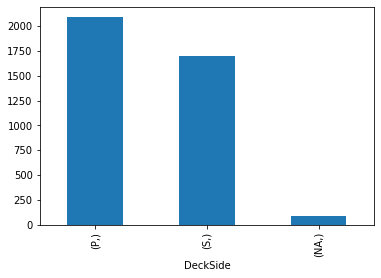

In [ ]:
df_exploration.loc[
    df_exploration['Transported'] == False,
    ['DeckSide']
].value_counts().plot(kind='bar')

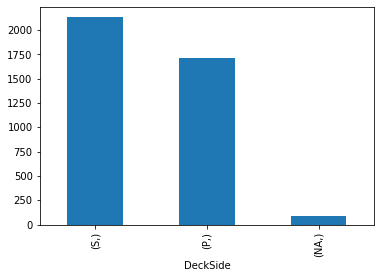

In [ ]:
df_exploration.loc[
    df_exploration['Transported'] == True,
    ['DeckSide']
].value_counts().plot(kind='bar')

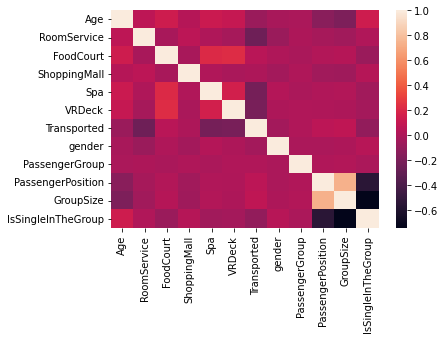

In [ ]:
import seaborn as sns
sns.heatmap(df_exploration.corr())

## Total spend

In [132]:
df_exploration['Total_Spend'] = \
    df_exploration['Spa'] \
    + df_exploration['FoodCourt'] \
    + df_exploration['VRDeck'] \
    + df_exploration['RoomService'] \
    + df_exploration['ShoppingMall']

(0.0, 5000.0)

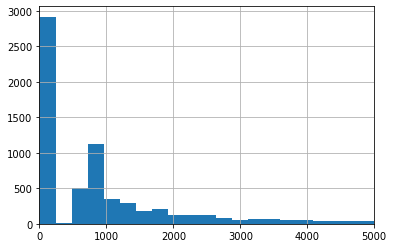

In [133]:
ax = df_exploration['Total_Spend'].hist(
    bins=150
)
ax.set_xlim(0, 5000)

In [155]:
df_exploration['SpendCategory'] = pd.cut(
    df_exploration['Total_Spend'],
    bins=[-1, 1, 100000],
    duplicates='drop'
    # labels=[i for i in ran]
)

prepare_pivot_table(
    df_=df_exploration,
    values_=['Transported'],
    index_=['SpendCategory'],
    aggfunc_=['sum', 'count']
)

,sum,count,%
,Transported,Transported,
SpendCategory,,,
"(-1, 1]",2279,2916,0.781550
"(1, 100000]",1240,4091,0.303104


In [151]:
N_QUANTILES = 10

df_exploration['SpendCategory'] = pd.qcut(
    df_exploration['Total_Spend'],
    q=N_QUANTILES,
    duplicates='drop'
    # labels=[i for i in ran]
)

prepare_pivot_table(
    df_=df_exploration,
    values_=['Transported'],
    index_=['SpendCategory'],
    aggfunc_=['sum', 'count']
)

,sum,count,%
,Transported,Transported,
SpendCategory,,,
"(-0.001, 736.0]",2459,3509,0.700769
"(736.0, 868.6]",198,695,0.284892
"(868.6, 1193.8]",210,701,0.299572
"(1193.8, 1985.2]",189,700,0.270000
"(1985.2, 3994.0]",225,704,0.319602
"(3994.0, 35987.0]",238,698,0.340974


,sum,count,%
,Transported,Transported,
SpendCategory,,,
"(-0.001, 736.0]",2459,3509,0.700769
"(736.0, 868.6]",198,695,0.284892
"(868.6, 1193.8]",210,701,0.299572
"(1193.8, 1985.2]",189,700,0.270000
"(1985.2, 3994.0]",225,704,0.319602
"(3994.0, 35987.0]",238,698,0.340974


In [134]:
df_exploration['Spend_Category'] = ''
df_exploration.loc[df_exploration['Total_Spend'].between(0, 1, 'left'), 'Spend_Category'] = 'Zero_Spend'
df_exploration.loc[df_exploration['Total_Spend'].between(1, 800, 'both'), 'Spend_Category'] = 'Under_800'
df_exploration.loc[df_exploration['Total_Spend'].between(800, 1200, 'right'), 'Spend_Category'] = 'Median_1200'
df_exploration.loc[df_exploration['Total_Spend'].between(1200, 2700, 'right'), 'Spend_Category'] = 'Upper_2700'
df_exploration.loc[df_exploration['Total_Spend'].between(2700, 100000, 'right'), 'Spend_Category'] = 'Big_Spender'

df_exploration['Spend_Category'] = \
    df_exploration['Spend_Category'].astype('category')

In [135]:
df_exploration['Spend_Category'].value_counts()

Zero_Spend     2916
Upper_2700     1067
Big_Spender    1035
Median_1200    1015
Under_800       974
                816
Name: Spend_Category, dtype: int64

## Total spend per group

In [136]:
unique_groups = df_exploration['PassengerGroup'].unique()
unique_groups

array([3645, 1083, 2663, ..., 4678, 5298, 7040])

In [137]:
total_spends_per_group = {}
for unique_group in unique_groups:
    subset = df_exploration.loc[
        df_exploration['PassengerGroup'] == unique_group,
        ['Total_Spend']
    ]
    total_spend_per_group = subset.fillna(subset.median()).sum() / len(subset)
    total_spends_per_group[unique_group] = total_spend_per_group.values

In [138]:
def get_total_spend_per_group(group_number):
    return total_spends_per_group[group_number][0]


df_exploration['TotalSpendPerGroup'] = \
    df_exploration['PassengerGroup'].map(get_total_spend_per_group)

In [139]:
df_exploration['TotalSpendPerGroup']

3388       0.000000
1013     471.333333
2483     815.000000
4431    2357.000000
951        0.000000
           ...     
4406     870.000000
4409     295.500000
4964       0.000000
3049       0.000000
6677       0.000000
Name: TotalSpendPerGroup, Length: 7823, dtype: float64

In [140]:
df_exploration.TotalSpendPerGroup.describe()

count     7823.000000
mean      1406.923559
std       2408.351871
min          0.000000
25%          0.000000
50%        719.000000
75%       1521.333333
max      35987.000000
Name: TotalSpendPerGroup, dtype: float64

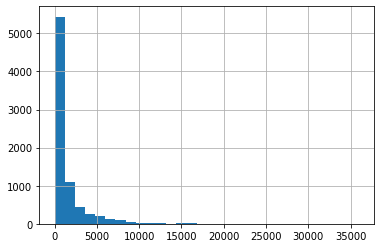

In [141]:
df_exploration.TotalSpendPerGroup.hist(bins=30)

## Spendless group of people (nobody spent anything in the group)

In [ ]:
df_exploration['IsFromSpendlessGroup'] = \
    df_exploration['TotalSpendPerGroup'] == 0

In [ ]:
prepare_pivot_table(
    df_exploration,
    values_=['Transported'],
    index_=['IsFromSpendlessGroup'],
    aggfunc_=['sum', 'count']
)

,sum,count,%
,Transported,Transported,
IsFromSpendlessGroup,,,
False,2159,5280,0.408902
True,1781,2543,0.700354


## Age group

Below we could see a "hint" on bimodal distribution. Perhaps, we could separate a group of kids

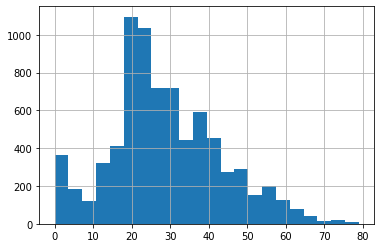

In [ ]:
df_exploration['Age'].hist(bins=22)

In [ ]:
df_exploration['AgeGroup'] = 'Not assigned'
df_exploration.loc[
    df_exploration['Age'].between(0, 10, 'both'),
    'AgeGroup'] = 'Kids'
df_exploration.loc[
    df_exploration['Age'].between(10, 18, 'right'),
    'AgeGroup'] = 'Teen'
df_exploration.loc[
    df_exploration['Age'].between(18, 35, 'right'),
    'AgeGroup'] = 'Middle'
df_exploration.loc[
    df_exploration['Age'].between(35, 50, 'right'),
    'AgeGroup'] = 'Senior'
df_exploration.loc[
    df_exploration['Age'].between(50, 100, 'right'),
    'AgeGroup'] = 'Old'

In [ ]:
df_exploration['AgeGroup'].value_counts()

Middle          3721
Senior          1609
Teen            1026
Kids             668
Old              642
Not assigned     157
Name: AgeGroup, dtype: int64

## Group size

In [ ]:
df_exploration['GroupSizeBinned'] = pd.cut(
    df_exploration['GroupSize'],
    # q=N_QUANTILES,
    bins=[0, 1, 2, 6, 8],
    duplicates='drop'
    # labels=[i for i in range(N_QUANTILES)]
)

prepare_pivot_table(
    df_exploration,
    values_=['Transported'],
    index_=['GroupSizeBinned'],
    aggfunc_=['sum', 'count'],
)

,sum,count,%
,Transported,Transported,
GroupSizeBinned,,,
"(0, 1]",2054,4484,0.458073
"(1, 2]",817,1526,0.535387
"(2, 6]",985,1635,0.602446
"(6, 8]",84,178,0.471910
